# LSTM Sentiment Classifier

In this notebook, we use an LSTM to classify IMDB movie reviews by their sentiment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/lstm_sentiment_classifier.ipynb)

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM # new!
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/LSTM'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 10000
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# LSTM layer architecture:
n_lstm = 256
drop_lstm = 0.2

# dense layer architecture:
# n_dense = 256
# dropout = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(LSTM(n_lstm, dropout=drop_lstm))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.6338 - loss: 0.6163 - val_accuracy: 0.8270 - val_loss: 0.3955
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8719 - loss: 0.3166 - val_accuracy: 0.8477 - val_loss: 0.3513
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 182s 928ms/step - accuracy: 0.8978 - loss: 0.2652 - val_accuracy: 0.8372 - val_loss: 0.3739
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9189 - loss: 0.2131 - val_accuracy: 0.8450 - val_loss: 0.3915


#### Evaluate

In [16]:
model.load_weights(output_dir+"/weights.02.keras")

In [18]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step


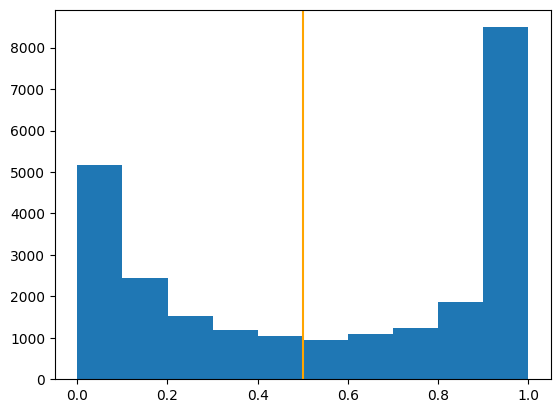

In [19]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [20]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.06'

In [23]:
import numpy as np

random_index = np.random.randint(0, len(x_valid))
random_review = x_valid[random_index]
random_label = y_valid[random_index]

print(f"Random Review Index: {random_index}")
print(f"Random Review (first 10 elements): {random_review[:10]}")
print(f"Random Label: {random_label}")

Random Review Index: 2279
Random Review (first 10 elements): [ 10  10  73  15  62  30 608  48   4   2]
Random Label: 0


In [24]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in random_review])

print(f"Decoded Review:\n{decoded_review}")
print(f"Actual Label: {random_label}")

Decoded Review:
br br well that would be ok if the ? weren't so ? ? i mean come on the best you can do is show few men that have problem with getting ? out of the bottle suzanne ? walking with halloween basket in july ice cream place that sells only vanilla i've seen few episodes and each time it was horrible they were posing like it's the greatest show ever and then fill the time with scenes so dull that i really felt embarrassed to watch even the people in them looked bored and that just can't be good
Actual Label: 0


## Predict the sentiment

### Subtask:
Use the trained model to predict the sentiment of the selected review.


**Reasoning**:
Reshape the random review and use the trained model to predict its sentiment.



In [25]:
random_review_reshaped = np.reshape(random_review, (1, max_review_length))
predicted_sentiment = model.predict(random_review_reshaped)
print(f"Predicted Sentiment: {predicted_sentiment[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted Sentiment: 0.07512670755386353


## Compare prediction to actual

### Subtask:
Compare the model's prediction to the actual sentiment label of the review.


**Reasoning**:
Compare the predicted sentiment with the actual label and print the result.



In [26]:
threshold = 0.5
if predicted_sentiment[0][0] >= threshold:
    predicted_label = 1
    predicted_sentiment_text = "Positive"
else:
    predicted_label = 0
    predicted_sentiment_text = "Negative"

if predicted_label == random_label:
    print(f"Prediction matches actual label. Predicted Sentiment: {predicted_sentiment_text}")
else:
    print(f"Prediction does not match actual label. Predicted Sentiment: {predicted_sentiment_text}, Actual Label: {random_label}")

Prediction matches actual label. Predicted Sentiment: Negative


In [27]:
print("--- Sentiment Prediction Results ---")
print(f"Review: {decoded_review}")
print(f"Actual Sentiment: {'Positive' if random_label == 1 else 'Negative'}")
print(f"Predicted Sentiment: {predicted_sentiment_text}")

--- Sentiment Prediction Results ---
Review: br br well that would be ok if the ? weren't so ? ? i mean come on the best you can do is show few men that have problem with getting ? out of the bottle suzanne ? walking with halloween basket in july ice cream place that sells only vanilla i've seen few episodes and each time it was horrible they were posing like it's the greatest show ever and then fill the time with scenes so dull that i really felt embarrassed to watch even the people in them looked bored and that just can't be good
Actual Sentiment: Negative
Predicted Sentiment: Negative
